## Data loading

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
import gresearch_crypto
import warnings
import time
import traceback
import xgboost as xgb
warnings.filterwarnings('ignore')

In [3]:
data_train = '/kaggle/input/g-research-crypto-forecasting/train.csv'
data_asset_details = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

In [4]:
%%time
df_train = pd.read_csv(data_train, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      )
df_train.head()

CPU times: user 31.1 s, sys: 2.53 s, total: 33.6 s
Wall time: 52.5 s


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [5]:
df_assets = pd.read_csv(data_asset_details).sort_values(by='Asset_ID')
df_assets.head()

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin


## Data preprocessing

In [6]:
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']


def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    df_feat["Median"] = df_feat[["Open", "High", "Low", "Close"]].median(axis=1)
    return df_feat

In [7]:
df_train = df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)

In [8]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    df["Count"] = df["Count"].astype(np.int16)

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1545.49 MB
Memory usage after optimization is: 515.16 MB
Decreased by 66.7%


In [9]:
xgb_params = {
    'n_estimators':2000,
    'max_depth':11,
    'learning_rate':0.05,
    'subsample':0.9,
    'colsample_bytree':0.7,
    'missing':-999,
    'random_state':2020,
    'tree_method':'gpu_hist'
}

In [10]:
def get_Xy_and_model_for_asset(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    X = get_features(df)
    y = df['Target']
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X, y)
    return model

## Training

In [11]:
%%time
models = {}

for asset_id, asset_name in zip(df_assets['Asset_ID'], df_assets['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    try:
        model = get_Xy_and_model_for_asset(df_train, asset_id)
        models[asset_id] = model
    except:         
        models[asset_id] = None

Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for Bitcoin Cash     (ID=2 )
Training model for Cardano          (ID=3 )
Training model for Dogecoin         (ID=4 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum         (ID=6 )
Training model for Ethereum Classic (ID=7 )
Training model for IOTA             (ID=8 )
Training model for Litecoin         (ID=9 )
Training model for Maker            (ID=10)
Training model for Monero           (ID=11)
Training model for Stellar          (ID=12)
Training model for TRON             (ID=13)
CPU times: user 21min 15s, sys: 7.94 s, total: 21min 23s
Wall time: 21min 25s


## Kaggle submission

In [12]:
%%time
env = gresearch_crypto.make_env()
iter_test = env.iter_test()


for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        if models[row['Asset_ID']] is not None:
            try:
                model = models[row['Asset_ID']]
                x_test = get_features(pd.DataFrame([row]))
                y_pred = model.predict(x_test)[0]
                df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
            except:
                df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
                traceback.print_exc()
        else: 
            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
CPU times: user 1.04 s, sys: 3.95 ms, total: 1.04 s
Wall time: 550 ms


## Results with different n_estimators

* 500 - 0.2126
* 1000 - 0.2659
* 1500 - 0.3038
* 2000 - 0.3362
* 3000 - 0.3743
* 4000 - 0.4023
* 4500 - Ended memory
* 5000 - Ended memory

In [1]:
import matplotlib.pyplot as plt
x = [500, 1000, 1500, 2000, 3000, 4000]
y = [0.2126, 0.2659, 0.3038, 0.3362, 0.3743, 0.4023]

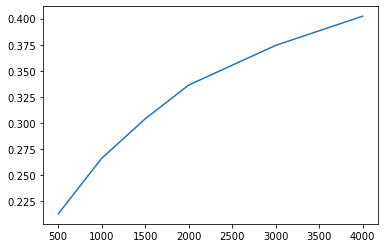

In [2]:
plt.plot(x,y)
plt.show()